In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
import torch

import sqlite3
import pandas as pd


triggers = pd.read_csv(
    'results/trigger_extraction_accuracy_with_response.csv')


In [41]:
triggers[triggers['grouped_trigger_label'].isnull()].shape


(21, 70)

In [28]:
for i in triggers['grouped_trigger_label']:
    if isinstance(i, float):
        print((i))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [6]:
my_list = [
    "trigger_0_zero_shot",
    "trigger_1_zero_shot",
    "trigger_2_zero_shot",
    "trigger_0_few_shot_1_include_multiple",
    "trigger_1_few_shot_1_include_multiple",
    "trigger_2_few_shot_1_include_multiple"
]


In [43]:
import pandas as pd


triggers['combined_zero_shot'] = triggers[["trigger_0_zero_shot",
    "trigger_1_zero_shot",
    "trigger_2_zero_shot"]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

triggers['combined_few_shot'] = triggers[["trigger_0_few_shot_1_include_multiple",
                                          "trigger_1_few_shot_1_include_multiple",
                                          "trigger_2_few_shot_1_include_multiple"]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [44]:
from collections import Counter
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


def top_keywords(df, column, n=10, exclude_words=[]):
    words = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for text in df[column]:
        if isinstance(text, str):
            tokens = word_tokenize(text.lower())
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
            lemmatized_tokens = [token.lower() for token in lemmatized_tokens]
            lemmatized_tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in lemmatized_tokens]
            filtered_tokens = [
            token for token in lemmatized_tokens if token not in stop_words and token not in string.punctuation and token not in exclude_words]
            words.extend(filtered_tokens)
    word_counts = Counter(words)
    return word_counts.most_common(n)


# exclude_words = ['eating', 'disorder', 'making', 'anorexia', 'body', 'ha', 'day', 'like', 'whether', 'due', 'taking', '``']
exclude_words = ['``', 'being', "''"]
for column in ['grouped_trigger_label', 'combined_few_shot', 'combined_zero_shot']:
    print(column)
    for df in [triggers]:
        print(f"Top keywords: {top_keywords(df, column, 10, exclude_words=exclude_words)}")
    print('\n')


grouped_trigger_label
Top keywords: [('feeling', 10), ('weight', 8), ('food', 7), ('feel', 7), ('body', 6), ('eating', 6), ('causing', 5), ('people', 5), ('bad', 5), ('writer', 4)]


combined_few_shot
Top keywords: [('weight', 33), ('body', 25), ('feeling', 21), ('fear', 17), ('mom', 15), ('eating', 15), ('food', 14), ('seeing', 12), ('change', 11), ('gain', 11)]


combined_zero_shot
Top keywords: [('weight', 27), ('feeling', 20), ('food', 19), ('gain', 13), ('body', 11), ('fear', 9), ('eat', 8), ('time', 8), ('like', 8), ('post', 7)]




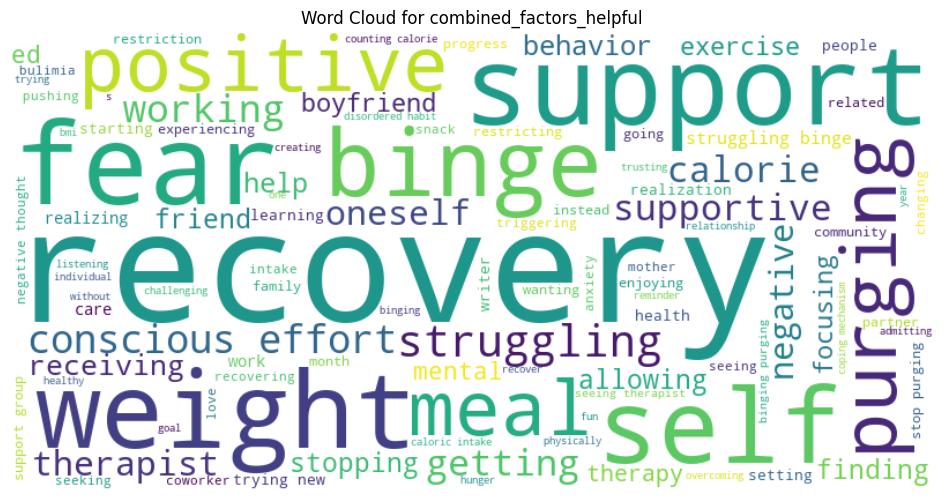

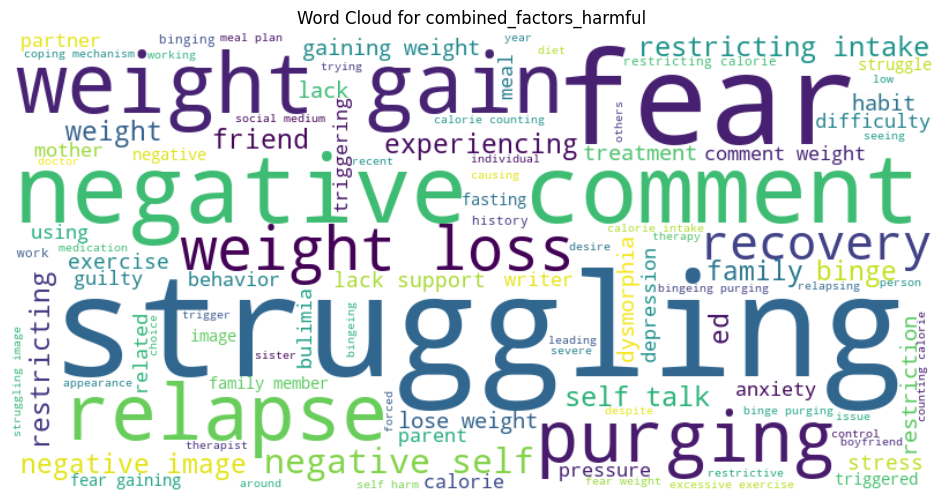

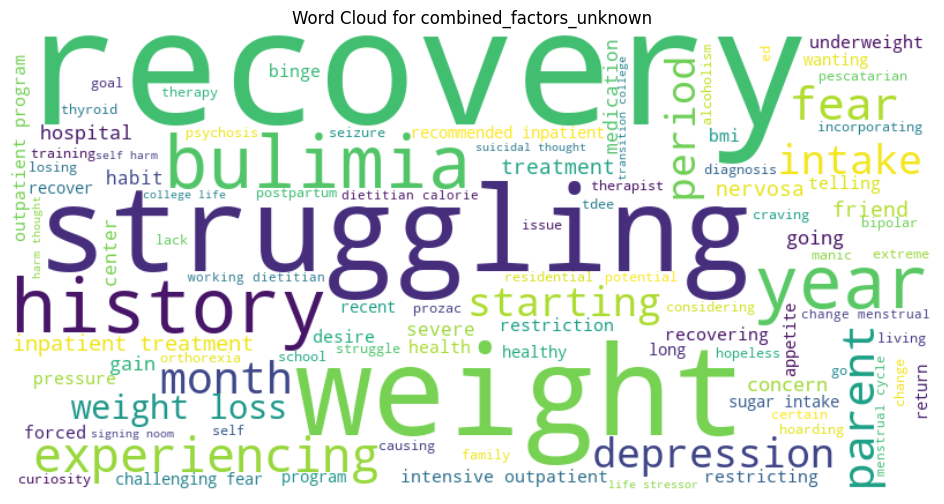

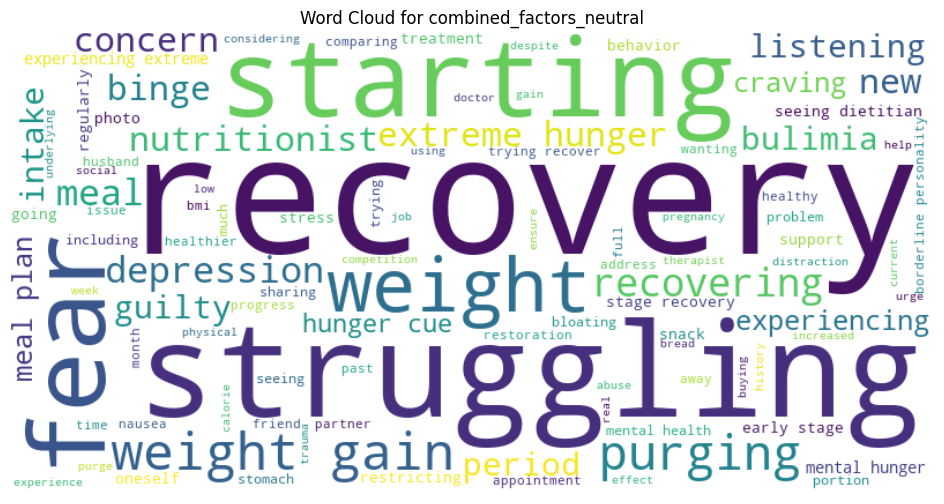

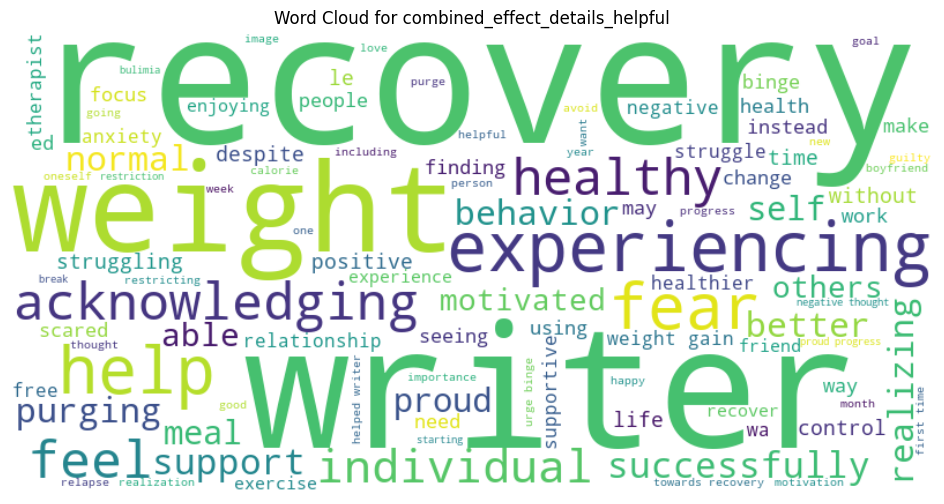

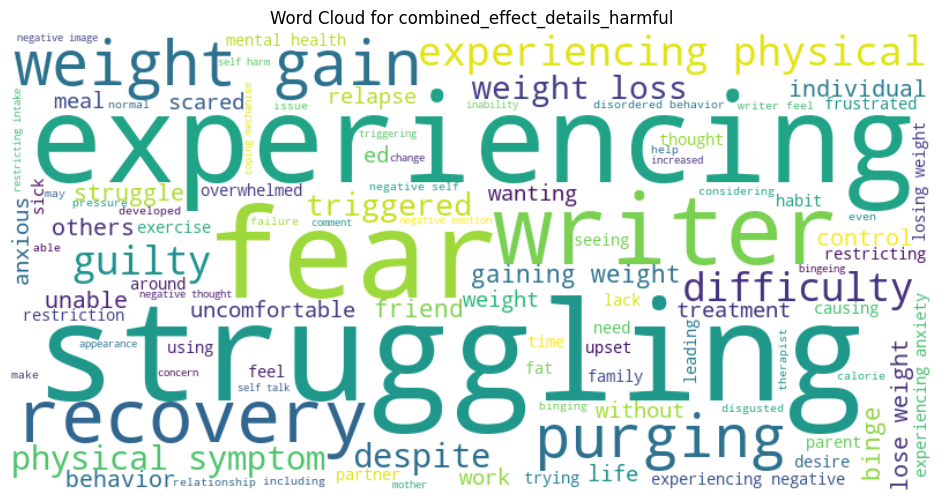

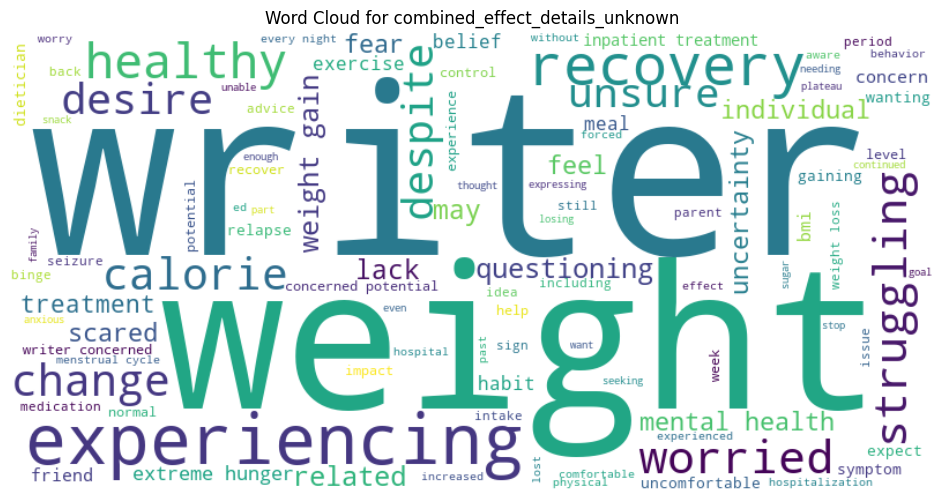

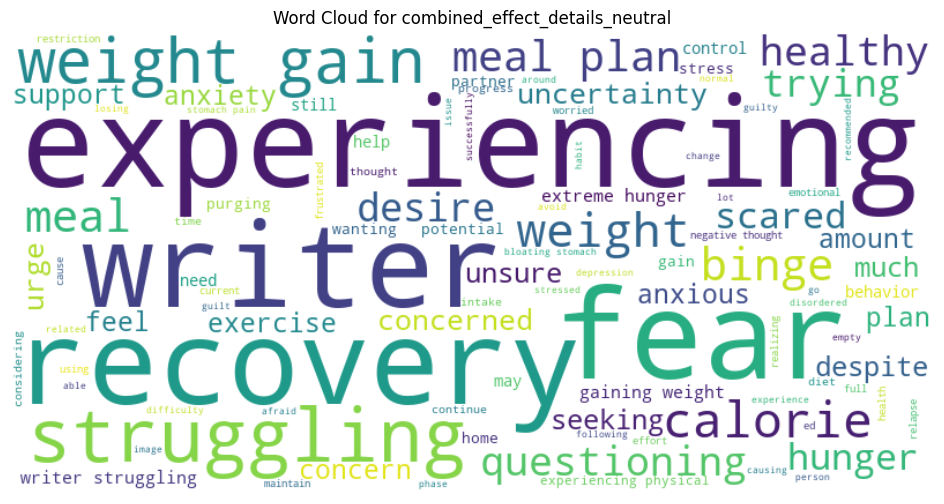

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

from nltk.stem import WordNetLemmatizer

def generate_wordcloud(df, column, title, exclude_words=[]):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    texts = df[column]
    filtered_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words and token not in string.punctuation and token not in exclude_words]
        filtered_words.extend(filtered_tokens)
    filtered_text = ' '.join(filtered_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(filtered_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {title}')
    plt.show()

for column in ['combined_few_shot', 'combined_zero_shot']:
    print(column)
        for df in [triggers]:
        
        generate_wordcloud(df, column, f"{column}_{effect_type}", exclude_words)


In [61]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(positive_df['selftext'])

def top_tfidf_features(cluster_texts, vectorizer, n=10):
    matrix = vectorizer.transform(cluster_texts)
    avg_tfidf = matrix.mean(axis=0).A1 
    sorted_indices = np.argsort(avg_tfidf)[::-1]
    return [(vectorizer.get_feature_names()[i], avg_tfidf[i]) for i in sorted_indices[:n]]

for cluster in range(optimal_n_clusters):
    cluster_texts = positive_df[positive_df['stb_cluster'] == cluster]['selftext']
    print(f"Top TF-IDF words in cluster {cluster}: {top_tfidf_features(cluster_texts, vectorizer)}")


Top TF-IDF words in cluster 0: [('like', 0.047755701439564945), ('just', 0.04530592685388768), ('ed', 0.03926673345119742), ('did', 0.035754037920775875), ('ve', 0.03425097733846667), ('don', 0.03282016142877411), ('today', 0.031230140347550117), ('time', 0.03115697031377127), ('really', 0.03078499627811674), ('think', 0.029045245908250993)]
Top TF-IDF words in cluster 1: [('like', 0.07216406300037313), ('eating', 0.06332073911251687), ('just', 0.0625929894558309), ('weight', 0.05777288591381082), ('eat', 0.05695678474271449), ('feel', 0.056551954031063584), ('ve', 0.05383393889601696), ('know', 0.050882090796253616), ('really', 0.045827161831744026), ('time', 0.04575476189792191)]


/Users/anthonycampbell/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
import pandas as pd
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer

# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_dict = {"J": "a", "N": "n", "V": "v", "R": "r"}


def common_pos_tags(texts, pos, n=10, exclude_words=[]):
    words = []
    lemmatizer = WordNetLemmatizer()
    for text in texts:
        if isinstance(text, str):
            tokens = word_tokenize(text)
            tokens = [token.lower() for token in tokens]
            tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in tokens]
            tagged_tokens = pos_tag(tokens)
            for word, tag in tagged_tokens:
                if tag.startswith(pos) and word.lower() not in stop_words and word.lower() not in exclude_words:
                    lemmatized_word = lemmatizer.lemmatize(
                        word, tag_dict.get(tag[0].upper(), 'n'))
                    words.append(lemmatized_word)
    word_counts = Counter(words)
    return word_counts.most_common(n)


exclude_words = ['example', 'test']  # List of words to exclude

# exclude_words = ['eating', 'disorder', 'making', 'eat', 'foods', 'anorexia',
#                  'food', 'body', 'feeling', 'ha', 'day', 'like', 'whether', 'due', 'taking']

exclude_words = ['``', 'being', "''", ']', '[', ""]

for column in ['grouped_trigger_label', 'combined_few_shot', 'combined_zero_shot']:
    for df in [triggers]:
        cluster_texts = df[column]  # replace this with the text column you want to analyze

        print(f"Top adjectives in {column}: {common_pos_tags(cluster_texts, 'JJ', 10, exclude_words)}")
        print(f"Top verbs in {column}: {common_pos_tags(cluster_texts, 'VB', 10, exclude_words)}")
        print(f"Top nouns in {column}: {common_pos_tags(cluster_texts, 'NN', 10, exclude_words)}")
        print("\n")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anthonycampbell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anthonycampbell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonycampbell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top adjectives in grouped_trigger_label: [('weight', 5), ('bad', 5), ('anxious', 3), ('diet', 2), ('unhealthy', 2), ('upset', 2), ('large', 2), ('hypocritical', 1), ('unhappy', 1), ('short', 1)]
Top verbs in grouped_trigger_label: [('feel', 10), ('eat', 8), ('cause', 8), ('make', 5), ('get', 3), ('compare', 3), ('go', 2), ('stress', 2), ('walk', 2), ('read', 1)]
Top nouns in grouped_trigger_label: [('food', 7), ('body', 6), ('people', 5), ('feeling', 4), ('writer', 4), ('selfimage', 4), ('feel', 3), ('boyfriend', 3), ('weight', 3), ('post', 2)]


Top adjectives in combined_few_shot: [('weight', 8), ('recent', 5), ('mental', 5), ('low', 5), ('chic', 3), ('loose', 3), ('slim', 3), ('due', 3), ('old', 3), ('new', 3)]
Top verbs in combined_few_shot: [('eat', 19), ('feel', 13), ('see', 12), ('comment', 9), ('purge', 8), ('look', 7), ('go', 7), ('want', 6), ('get', 5), ('work', 5)]
Top nouns in combined_few_shot: [('body', 25), ('weight', 23), ('fear', 18), ('comment', 15), ('mom', 15), ('fo